## Importing Necessary Libraries and SExtractor

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import subprocess

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib import patches

from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.stats import biweight_location, mad_std, sigma_clipped_stats, SigmaClip

from photutils.profiles import RadialProfile
from photutils.background import Background2D, SExtractorBackground
from photutils.segmentation import detect_threshold, detect_sources
from photutils.centroids import centroid_2dg

from scipy.ndimage import binary_dilation

import warnings
warnings.filterwarnings('ignore')

source_extractor = '/home/rabbit/sextractor-master/src/sex'

print("Libraries imported and SExtractor path set")

Libraries imported and SExtractor path set


## Plotting the FITS Image with the Headers

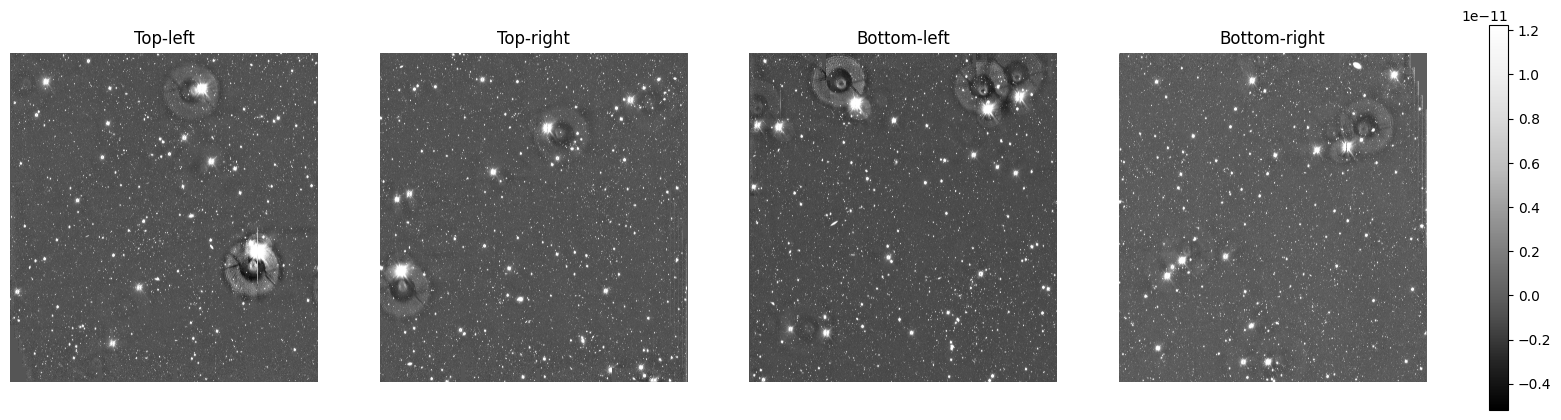

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                18711 / Number of pixels along this axis               NAXIS2  =                20033 / Number of pixels along this axis               EXTEND  =                    T / This file may contain FITS extensions          OBJECT  = 'KIDS_9.5_-33.1'                                                      ZEROPNT =                  0.0                                                  ZPNTERR =                  0.0                                                  CREADATE= '2018-05-09T00:41:45.000'                                             PSF_RAD =   0.6659591674804688                                                  INSTRUME= 'OMEGACAM'                                                            TELESCOP= 'ESO-VLT-U0'                  

In [2]:
fits_path = '/home/rabbit/PSF_BuildUp/FITS_images/KIDS_9.5_-33.1.fits'

with fits.open(fits_path, memmap=True) as hdul:
    data = hdul[0].data
    header = hdul[0].header  

ny, nx = data.shape
cy, cx = ny // 2, nx // 2


quad1 = data[:cy, :cx] 
quad2 = data[:cy, cx:]  
quad3 = data[cy:, :cx]   
quad4 = data[cy:, cx:]   

quads = [quad1, quad2, quad3, quad4]
titles = ['Top-left', 'Top-right', 'Bottom-left', 'Bottom-right']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for ax, q, t in zip(axes, quads, titles):
    im = ax.imshow(q, origin='lower', cmap='Greys_r',
                   vmin=np.percentile(q, 1),
                   vmax=np.percentile(q, 99))
    ax.set_title(t)
    ax.axis('off')

plt.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
plt.show()

print(header)

for key, value in header.items():
    print(f"{key}: {value}")

## Setting Outparameter and Convolution Filters

In [3]:
pixscale = 0.2

fitspath = '/home/rabbit/PSF_BuildUp/FITS_images/'
fits_pathlist = sorted(glob.glob(fitspath+'*.fits'))
fits_list = sorted([os.path.basename(f) for f in glob.glob(fitspath+'*.fits')])

seinpath = os.path.join(fitspath, 'se_in_out/')
os.makedirs(seinpath, exist_ok=True)

seinpath = os.path.join(fitspath, 'se_in_out/')
seoutpath = seinpath

out_param_path = os.path.join(seinpath, 'default.param')
conv_filter = '/usr/local/share/sextractor/gauss_3.0_7x7.conv'

## Setting up the Catalog

In [4]:
nnw_path = "/home/rabbit/PSF_BuildUp/FITS_images/se_in_out/default.nnw"
psf_path = "/home/rabbit/PSF_BuildUp/FITS_images/se_in_out/default.psf"

env = os.environ.copy()
env['LD_LIBRARY_PATH'] = '/home/rabbit/miniforge3/envs/psf/lib:' + env.get('LD_LIBRARY_PATH','')

for i, filename in enumerate(fits_list, start=1):

    image_file = fits_pathlist[i-1]
    base_name = os.path.splitext(filename)[0]

    cat_out_name = os.path.join(seoutpath, f'outparams_{base_name}.cat')
    template_path = os.path.join(seinpath, f'{base_name}.SEtemplate')

    with open(template_path, 'w') as f:
        f.write(f"""CATALOG_NAME     {cat_out_name}
CATALOG_TYPE     ASCII_HEAD
PARAMETERS_NAME  {out_param_path}

DETECT_TYPE      CCD
DETECT_MINAREA   5
DETECT_THRESH    1.0
ANALYSIS_THRESH  1.5

FILTER           Y
FILTER_NAME      {conv_filter}

DEBLEND_NTHRESH  32
DEBLEND_MINCONT  0.0005

CLEAN            Y
CLEAN_PARAM      1.0

WEIGHT_TYPE      NONE
WEIGHT_IMAGE     -

FLAG_IMAGE       flag.fits
FLAG_TYPE        OR

PHOT_APERTURES   10
PHOT_AUTOPARAMS  2.5,3.5
PHOT_PETROPARAMS 2.0,3.5
PHOT_AUTOAPERS   0.0,0.0

SATUR_LEVEL      1e10
SATUR_KEY        SATURATE

MAG_ZEROPOINT    0.0
MAG_GAMMA        4.0
GAIN             0
GAIN_KEY         GAIN
PIXEL_SCALE      {pixscale}

SEEING_FWHM      0.6659591674804688
STARNNW_NAME     {nnw_path}
PSF_NAME         {psf_path}

CHECKIMAGE_TYPE  SEGMENTATION,BACKGROUND,BACKGROUND_RMS
CHECKIMAGE_NAME  {seoutpath}/segmap_{base_name}.fits,{seoutpath}/bkg_{base_name}.fits,{seoutpath}/bkg_rms_{base_name}.fits

BACK_TYPE        AUTO
BACK_SIZE        256
BACK_FILTERSIZE  3

MEMORY_OBJSTACK  50000
MEMORY_PIXSTACK  3000000
MEMORY_BUFSIZE   8000

VERBOSE_TYPE     NORMAL
HEADER_SUFFIX    .head
WRITE_XML        N
XML_NAME         sex.xml
XSL_URL          file:///usr/local/share/sextractor/sextractor.xsl
""")

    print(f"\nSE template written for {base_name}")
    print(f"Running SExtractor for {base_name} ({i}/{len(fits_list)}) ...")

    try:
        subprocess.run(
            [source_extractor, image_file, '-c', template_path],
            check=True,
            env=env
        )
        print(f"SExtractor ran successfully for {base_name}")

    except subprocess.CalledProcessError as e:
        print(f"Warning: SExtractor failed for {base_name} (exit code {e.returncode})")

print(f"\nSExtractor ran for all {len(fits_list)} FITS files.")


SE template written for KIDS_9.5_-33.1
Running SExtractor for KIDS_9.5_-33.1 (1/2) ...


> 
----- SExtractor 2.29.0 started on 2026-02-25 at 00:07:48 with 12 threads

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for KIDS_9.5_-33.1.fits
----- Measuring from: KIDS_9.5_-33.1.fits
      "KIDS_9.5_-33.1" / no ext. header / 18711x20033 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  256
> Setting up background map at line:  512
> Setting up background map at line:  768
> Setting up background map at line: 1024
> Setting up background map at line: 1280
> Setting up background map at line: 1536
> Setting up background map at line: 1792
> Setting up background map at line: 2048
> Setting up background map at line: 2304
> Setting up background map at line: 2560
> Setting up background map at line: 2816
> Setting up background map at line: 3072
> Setting up background map at line: 33

SExtractor ran successfully for KIDS_9.5_-33.1

SE template written for cutout_251.0256_36.4566
Running SExtractor for cutout_251.0256_36.4566 (2/2) ...


> Line:   75  Objects:      289 detected /        0 sextracted
> Line:  100  Objects:      377 detected /        0 sextracted
> Line:  125  Objects:      472 detected /        0 sextracted
> Line:  150  Objects:      578 detected /        0 sextracted
> Line:  175  Objects:      686 detected /        0 sextracted
> Line:  200  Objects:      805 detected /        0 sextracted
> Line:  225  Objects:      915 detected /        0 sextracted
> Line:  250  Objects:     1020 detected /        0 sextracted
> Line:  275  Objects:     1107 detected /        0 sextracted
> Line:  300  Objects:     1205 detected /        0 sextracted
> Line:  325  Objects:     1279 detected /        0 sextracted
> Line:  350  Objects:     1354 detected /        0 sextracted
> Line:  375  Objects:     1437 detected /        0 sextracted
> Line:  400  Objects:     1522 detected /        0 sextracted
> Line:  425  Objects:     1613 detected /        0 sextracted
> Line:  450  Objects:     1704 detected /        0 sex

SExtractor ran successfully for cutout_251.0256_36.4566

SExtractor ran for all 2 FITS files.


> Line: 3000  Objects:    11627 detected /     3600 sextracted
> Line: 3000  Objects:    11627 detected /     4000 sextracted
> Line: 3000  Objects:    11627 detected /     4400 sextracted
> Line: 3000  Objects:    11627 detected /     4800 sextracted
> Line: 3000  Objects:    11627 detected /     5200 sextracted
> Line: 3000  Objects:    11627 detected /     5600 sextracted
> Line: 3000  Objects:    11627 detected /     6000 sextracted
      Objects: detected 11627    / sextracted 6156            

> Closing files
> 
> All done (in 1.2 s: 2488.7 lines/s , 5106.9 detections/s)



## Print the Segmentation Map

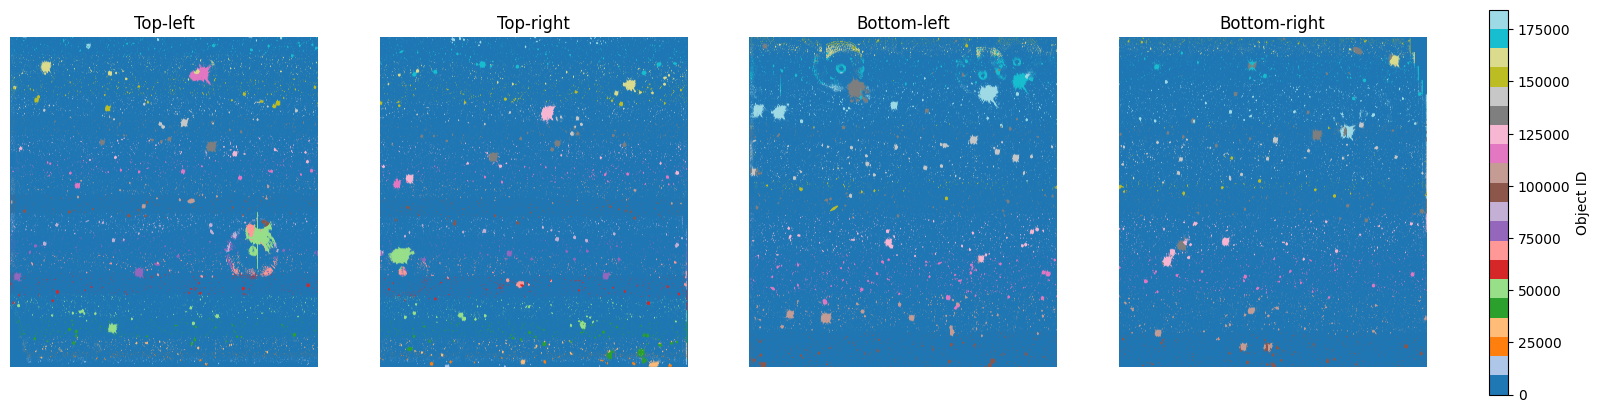

In [5]:
segmap_path = '/home/rabbit/PSF_BuildUp/FITS_images/se_in_out/segmap_KIDS_9.5_-33.1.fits'

with fits.open(segmap_path, memmap=True) as seg_hdu:
    seg_data = seg_hdu[0].data

ny, nx = seg_data.shape
cy, cx = ny // 2, nx // 2

quad1 = seg_data[:cy, :cx]
quad2 = seg_data[:cy, cx:]
quad3 = seg_data[cy:, :cx]
quad4 = seg_data[cy:, cx:]

quads = [quad1, quad2, quad3, quad4]
titles = ['Top-left', 'Top-right', 'Bottom-left', 'Bottom-right']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, q, t in zip(axes, quads, titles):
    im = ax.imshow(q, origin='lower', cmap='tab20')
    ax.set_title(t)
    ax.axis('off')

plt.colorbar(im, ax=axes, fraction=0.046, pad=0.04, label='Object ID')
plt.show()

## Plotting the Background and Bankground Substracted Images

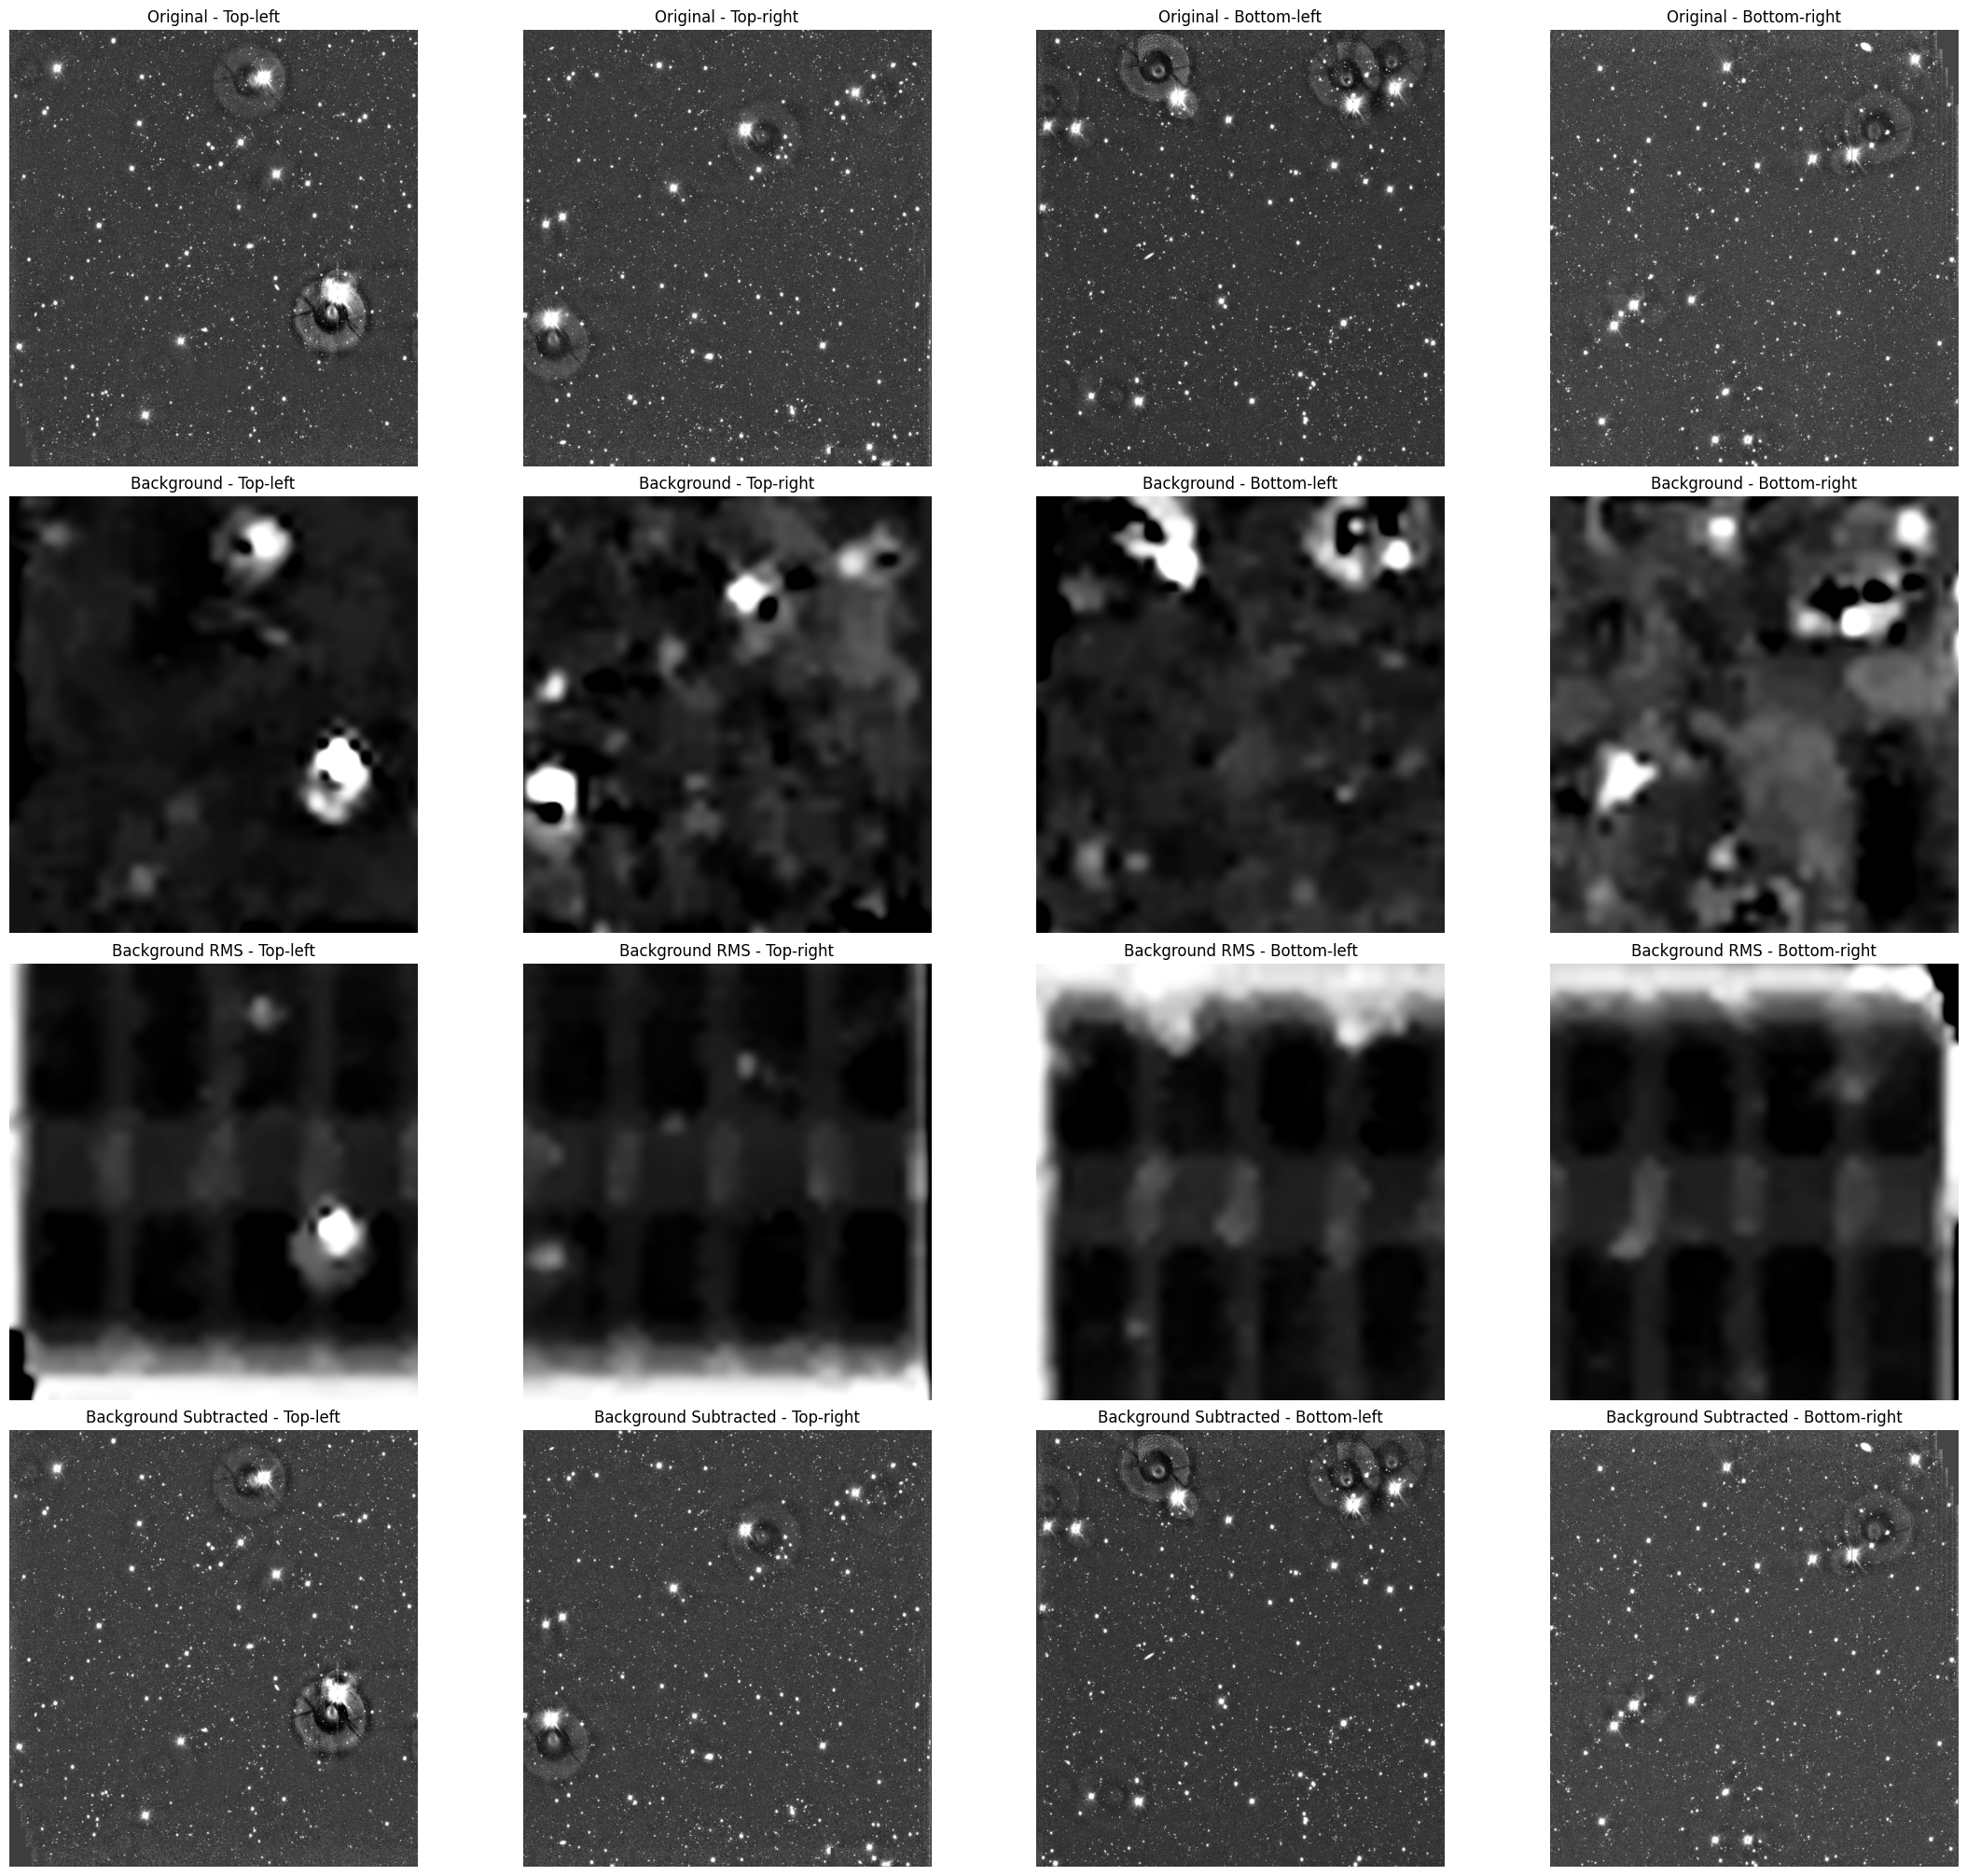

Background-subtracted image saved to: /home/rabbit/PSF_BuildUp/FITS_images/se_in_out/bkg_bySExtractor.fits


In [6]:
fits_path = '/home/rabbit/PSF_BuildUp/FITS_images/KIDS_9.5_-33.1.fits'
bkg_path = '/home/rabbit/PSF_BuildUp/FITS_images/se_in_out/bkg_KIDS_9.5_-33.1.fits'
bkg_rms_path = '/home/rabbit/PSF_BuildUp/FITS_images/se_in_out/bkg_rms_KIDS_9.5_-33.1.fits'

with fits.open(fits_path, memmap=True) as hdul_raw, \
     fits.open(bkg_path, memmap=True) as hdul_bkg, \
     fits.open(bkg_rms_path, memmap=True) as hdul_rms:

    raw_data = hdul_raw[0].data
    header = hdul_raw[0].header
    bkg_data = hdul_bkg[0].data
    bkg_rms_data = hdul_rms[0].data

subtracted_data = raw_data - bkg_data


def split_quads(data):
    ny, nx = data.shape
    cy, cx = ny // 2, nx // 2
    return [
        data[:cy, :cx],   
        data[:cy, cx:],   
        data[cy:, :cx],   
        data[cy:, cx:]   
    ]


datasets = [
    split_quads(raw_data),
    split_quads(bkg_data),
    split_quads(bkg_rms_data),
    split_quads(subtracted_data)
]

row_titles = [
    'Original',
    'Background',
    'Background RMS',
    'Background Subtracted'
]

quad_titles = ['Top-left', 'Top-right', 'Bottom-left', 'Bottom-right']


fig, axes = plt.subplots(4, 4, figsize=(22, 20), constrained_layout=True)

for i in range(4):        
    for j in range(4):    
        q = datasets[i][j][::4, ::4]
        vmin, vmax = np.percentile(q, 5), np.percentile(q, 99)

        im = axes[i, j].imshow(q,
                               origin='lower',
                               cmap='Greys_r',
                               vmin=vmin,
                               vmax=vmax)

        axes[i, j].set_title(f'{row_titles[i]} - {quad_titles[j]}')
        axes[i, j].axis('off')

plt.show()


out_dir = '/home/rabbit/PSF_BuildUp/FITS_images/se_in_out/'
os.makedirs(out_dir, exist_ok=True)

bkg_sub_path = os.path.join(out_dir, 'bkg_bySExtractor.fits')

fits.writeto(bkg_sub_path,
             subtracted_data.astype('float32'),
             header=header,
             overwrite=True)

print(f"Background-subtracted image saved to: {bkg_sub_path}")

## Estimate the Background using Photutils library

## Identify the Point Sources

Found 367 point sources
           X_IMAGE     Y_IMAGE  MAG_AUTO  CLASS_STAR
944      9306.9053     32.9543   23.5823       0.990
947     14460.6250     35.1244   23.7472       0.996
1698    16290.4746     50.9115   23.0056       0.995
1721    13306.3740     54.4806   22.7270       0.999
3137    14931.0029    100.6037   22.1228       1.000
...            ...         ...       ...         ...
183422  10452.4258  17483.9238   15.5273       0.995
183506  11609.6719  17482.4023   14.5464       1.000
183582  10000.0605  17552.2988   15.6663       0.995
183673  13156.3447  17518.9102   16.7068       0.995
184381  18355.5039  17407.5527   15.8433       0.998

[367 rows x 4 columns]


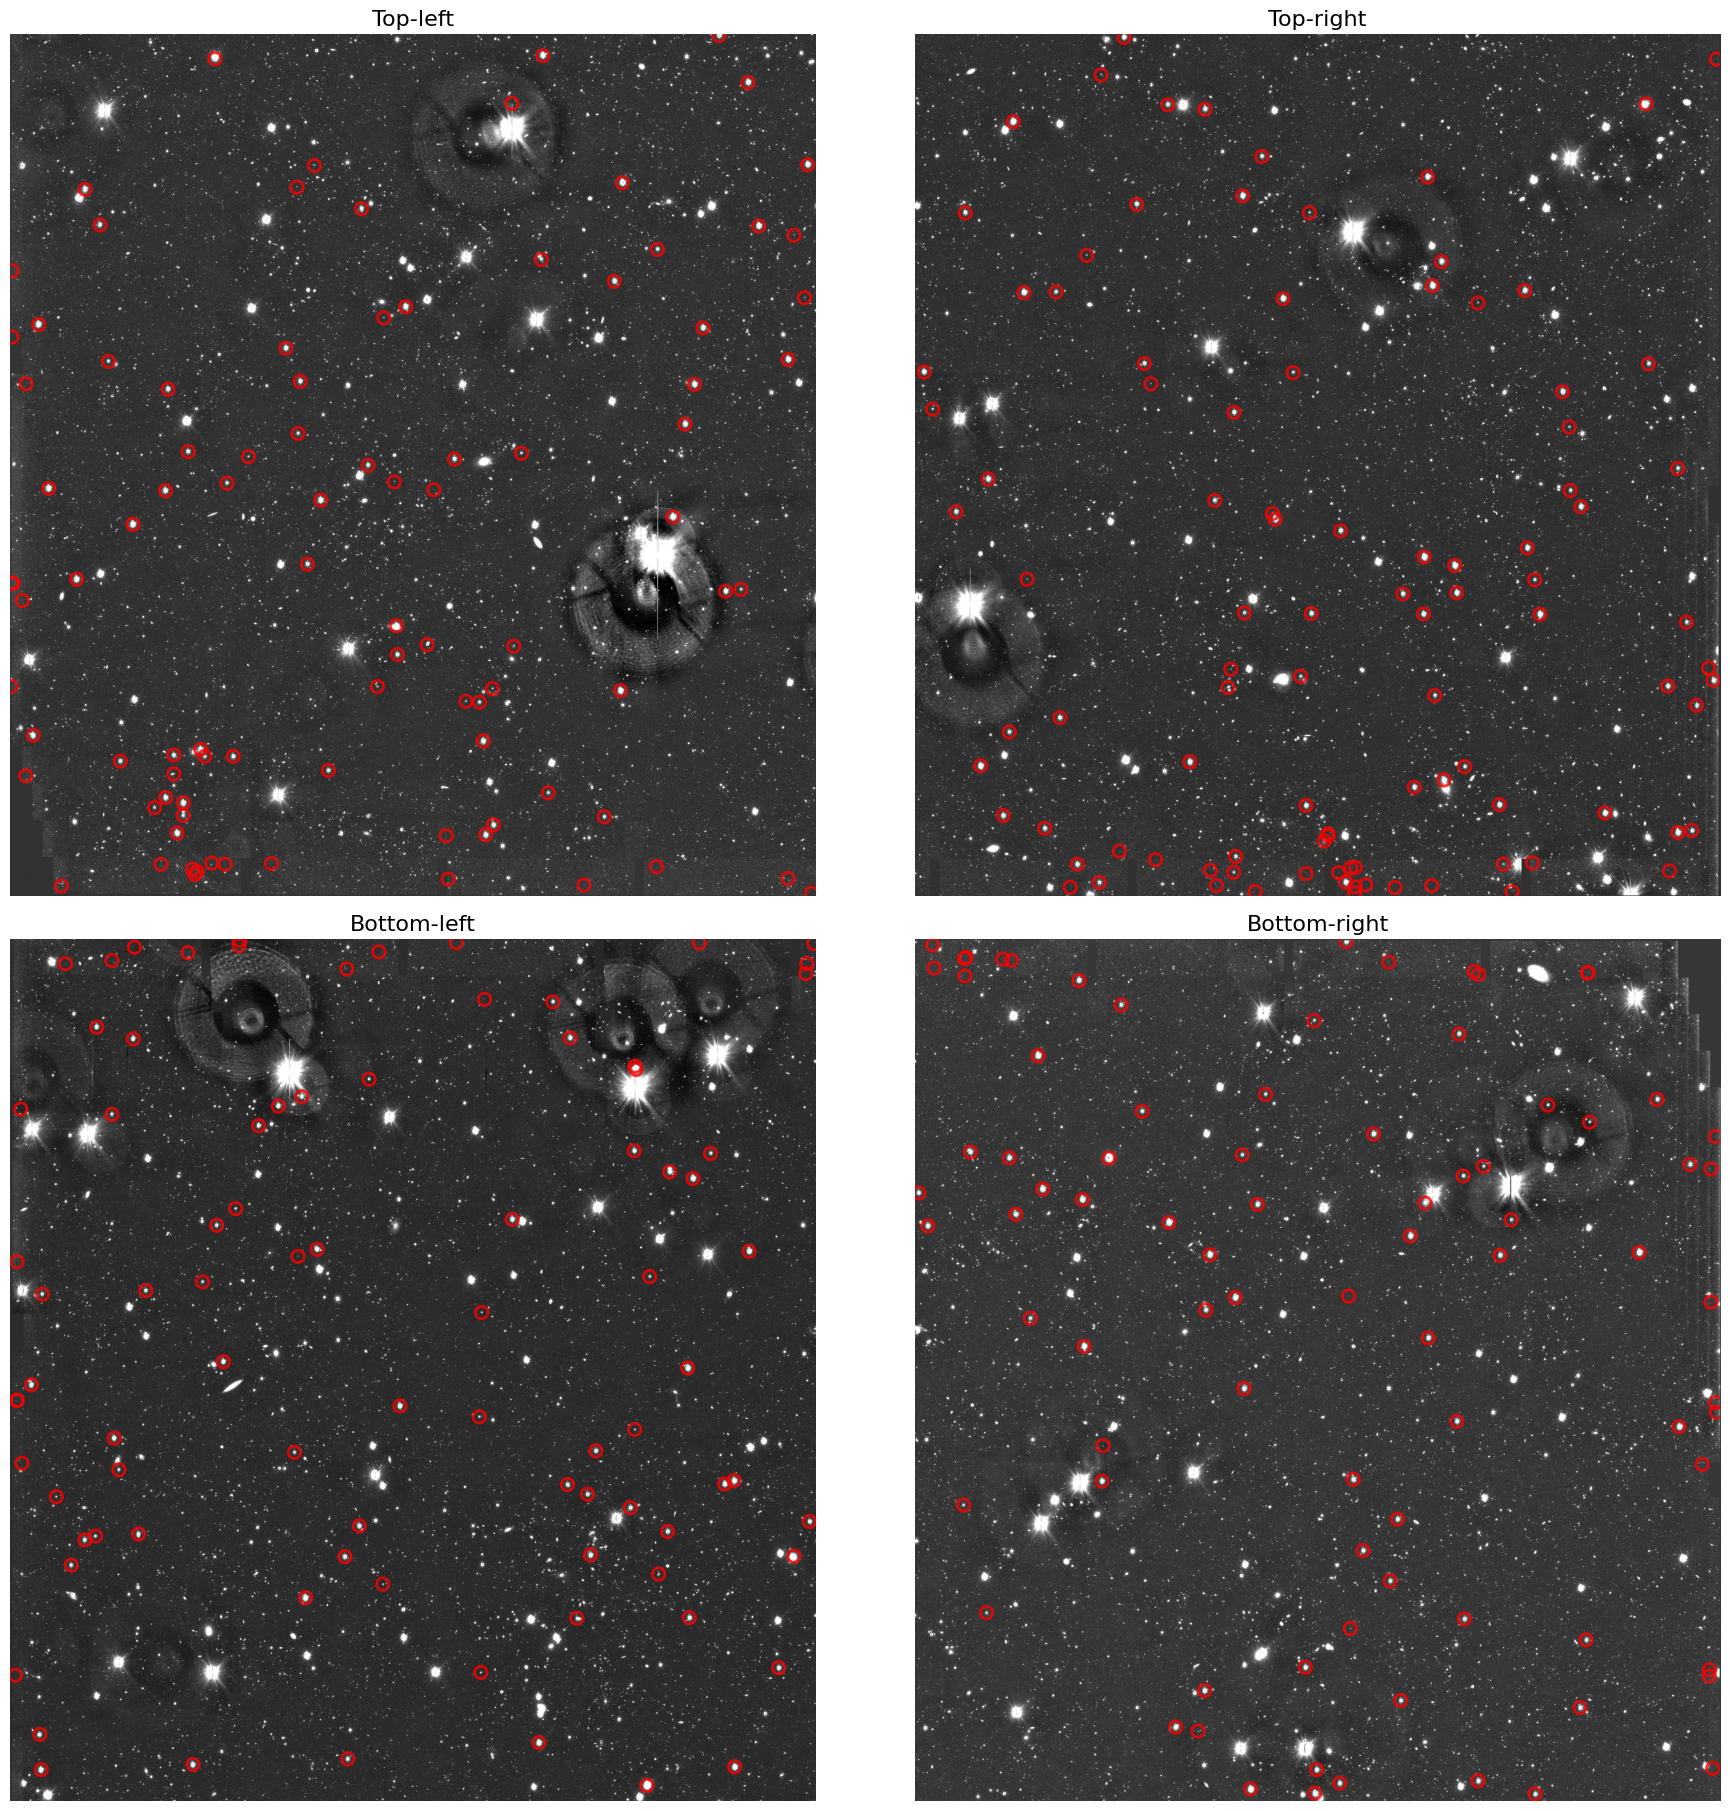

In [7]:
fits_path = '/home/rabbit/PSF_BuildUp/FITS_images/se_in_out/bkg_bySExtractor.fits'
cat_file = '/home/rabbit/PSF_BuildUp/FITS_images/se_in_out/outparams_KIDS_9.5_-33.1.cat'

with fits.open(fits_path, memmap=True) as hdul:
    img_data = hdul[0].data

columns = []
with open(cat_file, 'r') as f:
    for line in f:
        if line.startswith('#'):
            parts = line.replace('#','').strip().split()
            if len(parts) >= 2:
                columns.append(parts[1])
        else:
            break
catalog = pd.read_csv(cat_file, comment='#', sep=r'\s+', names=columns)

point_sources = catalog[catalog['CLASS_STAR'] >= 0.99]
print(f"Found {len(point_sources)} point sources")
print(point_sources[['X_IMAGE', 'Y_IMAGE', 'MAG_AUTO', 'CLASS_STAR']])


def split_quadrants(image, sources):
    ny, nx = image.shape
    cy, cx = ny // 2, nx // 2
    
    quads = [
        image[:cy, :cx],  
        image[:cy, cx:],
        image[cy:, :cx],  
        image[cy:, cx:]   
    ]
    
    source_quads = []
    for qx, qy, qimg in [(0, 0, quads[0]), (cx, 0, quads[1]), (0, cy, quads[2]), (cx, cy, quads[3])]:
        mask = (
            (point_sources['X_IMAGE'] >= qx) & 
            (point_sources['X_IMAGE'] < qx + qimg.shape[1]) &
            (point_sources['Y_IMAGE'] >= qy) & 
            (point_sources['Y_IMAGE'] < qy + qimg.shape[0])
        )
        sources_in_quad = point_sources[mask].copy()
        sources_in_quad['X_IMAGE'] -= qx
        sources_in_quad['Y_IMAGE'] -= qy
        source_quads.append(sources_in_quad)
    
    return quads, source_quads

image_quads, sources_quads = split_quadrants(img_data, point_sources)

quad_titles = ['Top-left', 'Top-right', 'Bottom-left', 'Bottom-right']

fig, axes = plt.subplots(2, 2, figsize=(18, 18), constrained_layout=True)

for ax, qimg, qs, title in zip(axes.flat, image_quads, sources_quads, quad_titles):
    vmin, vmax = np.percentile(qimg, 5), np.percentile(qimg, 99)
    ax.imshow(qimg, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
    ax.scatter(
        qs['X_IMAGE'].values,
        qs['Y_IMAGE'].values,
        s=80,
        edgecolor='red',
        facecolors='none',
        linewidth=2,
        alpha=0.8
    )
    ax.set_title(title, fontsize=16)
    ax.axis('off')

plt.show()

## Mag_Auto vs Flux_Radius Visualization

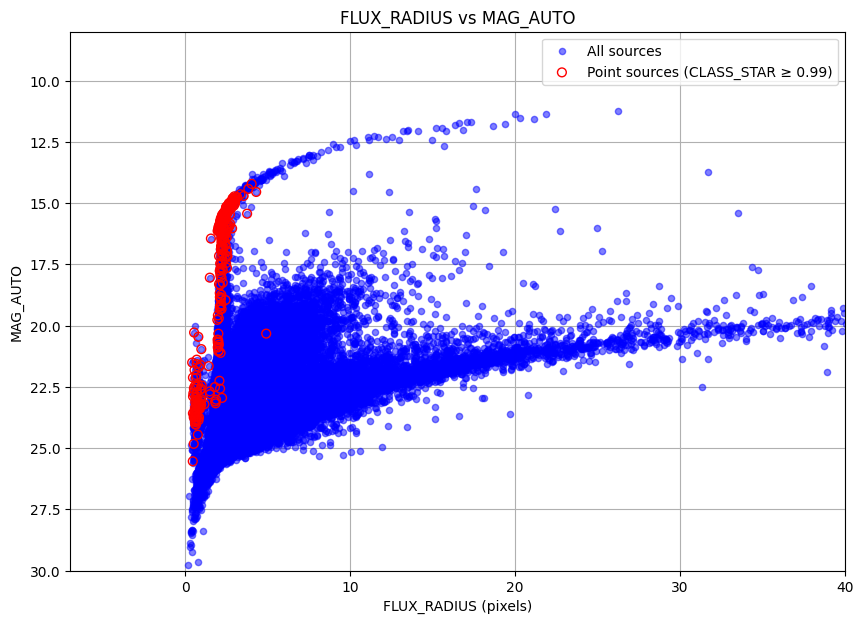

In [8]:
cat_file = '/home/rabbit/PSF_BuildUp/FITS_images/se_in_out/outparams_KIDS_9.5_-33.1.cat'

columns = []
with open(cat_file, 'r') as f:
    for line in f:
        if line.startswith('#'):
            parts = line.replace('#','').strip().split()
            if len(parts) >= 2:
                columns.append(parts[1])
        else:
            break

catalog = pd.read_csv(cat_file, comment='#', sep=r'\s+', names=columns)
point_sources = catalog[catalog['CLASS_STAR'] >= 0.99]

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(catalog['FLUX_RADIUS'], catalog['MAG_AUTO'], s=20, color='blue', alpha=0.5, label='All sources')
ax.scatter(point_sources['FLUX_RADIUS'], point_sources['MAG_AUTO'], s=40,
           edgecolor='red', facecolors='none', label='Point sources (CLASS_STAR ≥ 0.99)')

'''rects = [
    ((3.3, 15.6), 1.4, 3.4, 'teal'),
    ((4.2, 13.8), 2.4, 1.1, 'blue'),
    ((7.1, 12.8), 2.8, 1.1, 'orange'),
    ((11.7, 11.6), 6.7, 1.2, 'pink')
]
for (x,y), w, h, color in rects:
    ax.add_patch(patches.Rectangle((x,y), w, h, linewidth=1, edgecolor=color, facecolor='none'))'''

ax.set_xlim(-7,40)
ax.set_ylim(30, 8)  
ax.set_xlabel('FLUX_RADIUS (pixels)')
ax.set_ylabel('MAG_AUTO')
ax.set_title('FLUX_RADIUS vs MAG_AUTO')
ax.legend()
ax.grid(True)
ax.set_axisbelow(True)
plt.show()

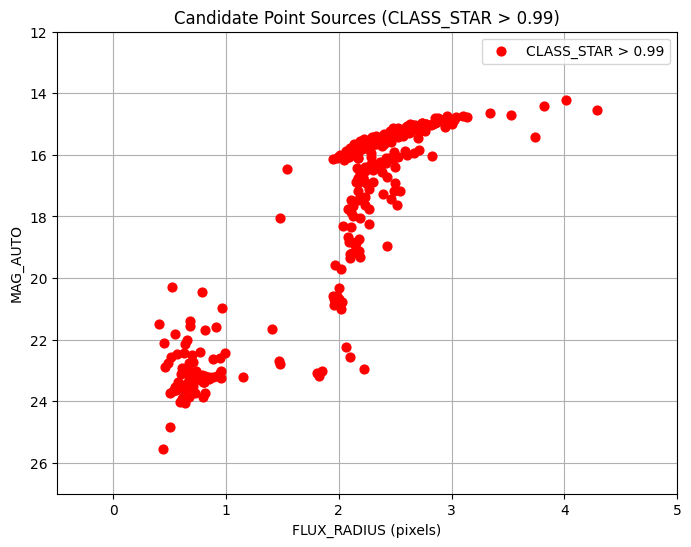

Total candidate stars: 346


In [9]:
columns = []
with open(cat_file, 'r') as f:
    for line in f:
        if line.startswith('#'):
            parts = line.replace('#','').strip().split()
            if len(parts) >= 2:
                columns.append(parts[1])
        else:
            break

catalog = pd.read_csv(cat_file, comment='#', sep=r'\s+', names=columns)

point_sources = catalog[catalog['CLASS_STAR'] > 0.99]
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(point_sources['FLUX_RADIUS'], point_sources['MAG_AUTO'],
           s=40, edgecolor='red', facecolors='red', label='CLASS_STAR > 0.99')

ax.set_xlim(-0.5, 5)
ax.set_ylim(27, 12)  
ax.set_xlabel('FLUX_RADIUS (pixels)')
ax.set_ylabel('MAG_AUTO')
ax.set_title('Candidate Point Sources (CLASS_STAR > 0.99)')
ax.legend()
ax.grid(True)
ax.set_axisbelow(True)
plt.show()

print(f"Total candidate stars: {len(point_sources)}")